In [147]:
import numpy as np
import pandas as pd
import geopandas as gp

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt

# Load the json file with county coordinates
geoData = gp.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

In [171]:
df = pd.read_csv('./US_MaizeYield+Predictors_1950-2013.csv')
df['fips'] = df['fips'].astype(str).astype(int)

# df['year2'] = df['year']**2
# df['prcp'] = df['prcp_4'] + df['prcp_5'] + df['prcp_6'] + df['prcp_7'] + df['prcp_8'] + df['prcp_9']
# df['prcp2'] = df['prcp2_4'] + df['prcp2_5'] + df['prcp2_6'] + df['prcp2_7'] + df['prcp2_8'] + df['prcp2_9']
# df['GDD'] = df['GDD_4'] + df['GDD_5'] + df['GDD_6'] + df['GDD_7'] + df['GDD_8'] + df['GDD_9']

# drop counties with less than 30 obs
good_counties = df.groupby('fips').count()['yield'] >= 30 
df = df.set_index('fips')
df = df.loc[good_counties]
df = df.sort_values(by = ['fips', 'year'])

In [172]:
df.columns

Index(['yield', 'year', 'state', 'area', 'EDD_4', 'GDD_4', 'prcp_4',
       'SM_mean_4', 'SM_week_max_4', 'SM_week_min_4', 'SM_mean2_4', 'prcp2_4',
       'EDD_5', 'GDD_5', 'prcp_5', 'SM_mean_5', 'SM_week_max_5',
       'SM_week_min_5', 'SM_mean2_5', 'prcp2_5', 'EDD_6', 'GDD_6', 'prcp_6',
       'SM_mean_6', 'SM_week_max_6', 'SM_week_min_6', 'SM_mean2_6', 'prcp2_6',
       'EDD_7', 'GDD_7', 'prcp_7', 'SM_mean_7', 'SM_week_max_7',
       'SM_week_min_7', 'SM_mean2_7', 'prcp2_7', 'EDD_8', 'GDD_8', 'prcp_8',
       'SM_mean_8', 'SM_week_max_8', 'SM_week_min_8', 'SM_mean2_8', 'prcp2_8',
       'EDD_9', 'GDD_9', 'prcp_9', 'SM_mean_9', 'SM_week_max_9',
       'SM_week_min_9', 'SM_mean2_9', 'prcp2_9', 'maize_irr_frac'],
      dtype='object')

In [175]:
# Choose subset of predictors
predictors = ['year', 'maize_irr_frac',
              'GDD_4', 'GDD_9',
              'EDD_8', 'EDD_9']

In [176]:
# Linear model
results_reg = {}
results_reg_r2_5fcv = {}

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

for fips in df.index.unique():
    X = df.loc[fips][predictors].to_numpy()
    y = df.loc[fips]['yield'].to_numpy()
    
    if len(y) > 30:
        reg = linear_model.LinearRegression()
        reg.fit(X, y)
        results_reg.update({fips : reg.coef_})
        results_reg_r2_5fcv.update({fips : np.mean(cross_val_score(linear_model.LinearRegression(), X, y, cv=cv, scoring='r2'))})

In [177]:
# how many counties show an out-of-sample R2 > 0?
(np.array(list(results_reg_r2_5fcv.values())) > 0.).mean()

0.9531113058720421

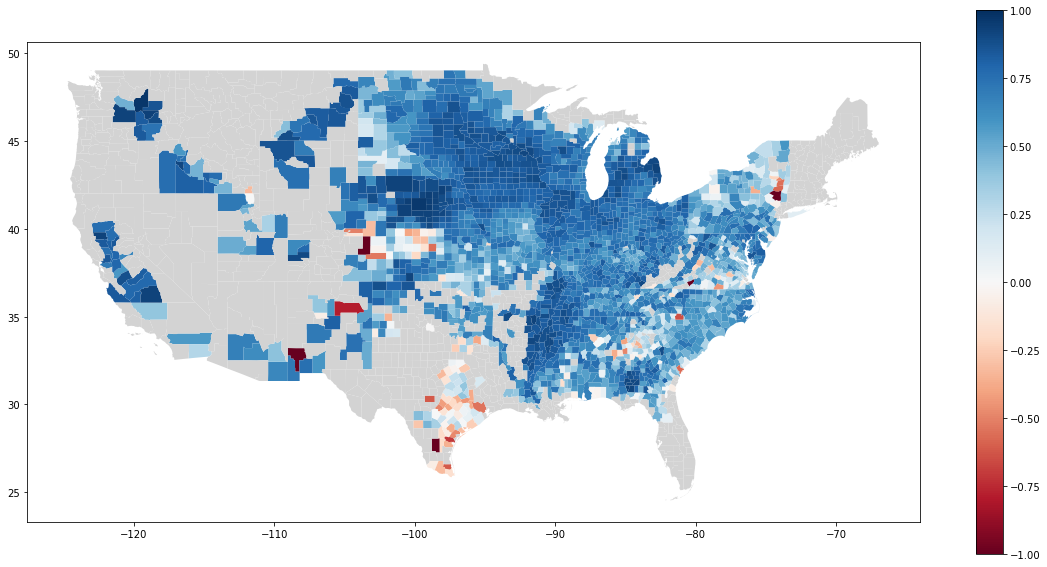

In [179]:
# Merge to plot out of sample R2
df_results = pd.DataFrame.from_dict(results_reg_r2_5fcv, orient='index', columns = ['R2']).reset_index()
df_results = pd.merge(geoData, df_results, right_on = 'index', left_on = 'id', how='outer')

# Plot R2
fig, ax = plt.subplots(figsize=(20,10))

df_results.plot(column = 'R2', ax=ax, legend=True, cmap = 'RdBu', missing_kwds={'color': 'lightgrey'}, vmin=-1., vmax=1.)

plt.show()

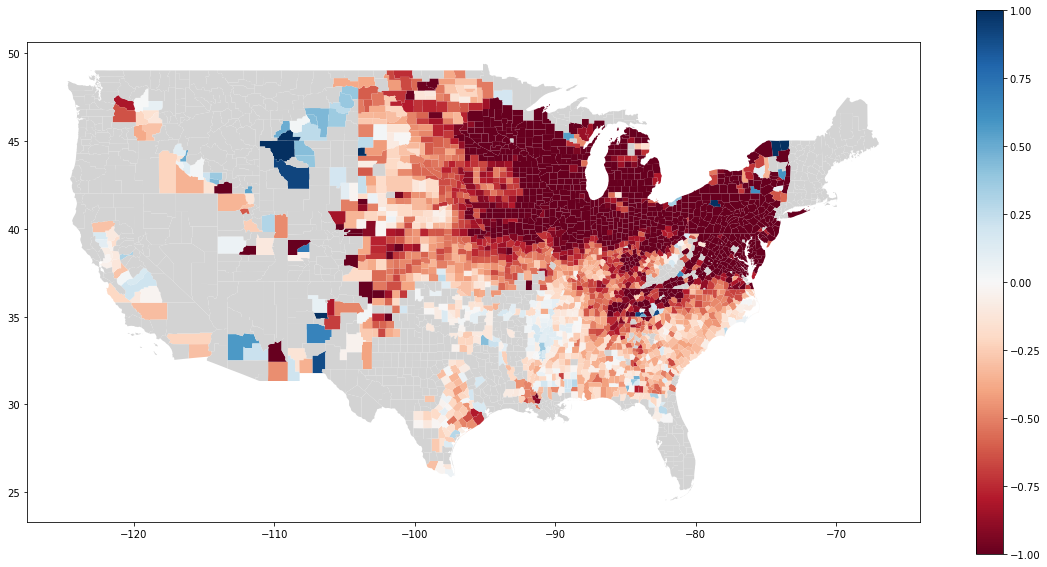

In [180]:
# Merge to plot EDD_8
df_results = pd.DataFrame.from_dict(results_reg, orient='index', columns = predictors).reset_index()
df_results = pd.merge(geoData, df_results, right_on = 'index', left_on = 'id', how='outer')

# Plot R2
fig, ax = plt.subplots(figsize=(20,10))

df_results.plot(column = 'EDD_8', ax=ax, legend=True, cmap = 'RdBu', missing_kwds={'color': 'lightgrey'}, vmin=-1., vmax=1.)

plt.show()

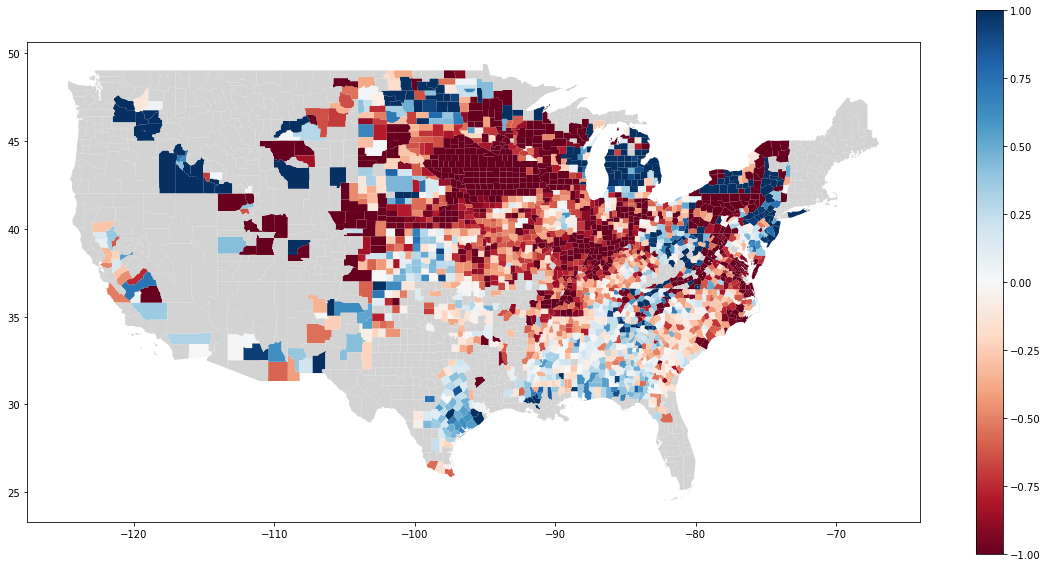

In [181]:
# Merge to plot EDD_9
df_results = pd.DataFrame.from_dict(results_reg, orient='index', columns = predictors).reset_index()
df_results = pd.merge(geoData, df_results, right_on = 'index', left_on = 'id', how='outer')

# Plot R2
fig, ax = plt.subplots(figsize=(20,10))

df_results.plot(column = 'EDD_9', ax=ax, legend=True, cmap = 'RdBu', missing_kwds={'color': 'lightgrey'}, vmin=-1., vmax=1.)

plt.show()

In [183]:
# OLD from here

In [130]:
# Ridge model
results_ridge = {}
results_ridge_r2_5fcv = {}

for fips in df.index.unique():
    X = df.loc[fips][predictors].to_numpy()
    y = df.loc[fips]['yield'].to_numpy()
    
    if len(y) > 30:
        reg = linear_model.Ridge(alpha=1.)
        reg.fit(X, y)
        results_ridge.update({fips : reg})
        results_ridge_r2_5fcv.update({fips : np.mean(cross_val_score(linear_model.Ridge(alpha=.5), X, y, cv=5, scoring='r2'))})

In [131]:
(np.array(list(results_ridge_r2_5fcv.values())) > 0.).mean()

0.14548641542506574

In [132]:
# TheilSenRegressor
results_ts = {}
results_ts_r2_5fcv = {}

for fips in df.index.unique():
    X = df.loc[fips][predictors].to_numpy()
    y = df.loc[fips]['yield'].to_numpy()
    
    if len(y) > 30:
        reg = linear_model.TheilSenRegressor()
        reg.fit(X, y)
        results_ts.update({fips : reg})
        results_ts_r2_5fcv.update({fips : np.mean(cross_val_score(linear_model.TheilSenRegressor(), X, y, cv=5, scoring='r2'))})

KeyboardInterrupt: 

In [ ]:
(np.array(list(results_ts_r2_5fcv.values())) > 0.).mean()

In [133]:
%%time
# Random forest
results_rf = {}
results_rf_r2_5fcv = {}

for fips in df.index.unique():
    X = df.loc[fips][predictors].to_numpy()
    y = df.loc[fips]['yield'].to_numpy()
    
    if len(y) > 30:
#         regr = RandomForestRegressor(max_depth=2)
#         regr.fit(X, y)
#         results_regr.update({fips : reg})
        results_rf_r2_5fcv.update({fips : np.mean(cross_val_score(RandomForestRegressor(n_estimators=20, max_depth=2), X, y, cv=5, scoring='r2'))})

KeyboardInterrupt: 

In [134]:
(np.array(list(results_rf_r2_5fcv.values())) > 0.).mean()

0.0029154518950437317

In [119]:
def plot_linreg(fips):
    fig, ax = plt.subplots(figsize = (10,5))
    
    # Predictions
    X = df.loc[fips][predictors].to_numpy()
    ax.plot(X[:,0], results_reg[fips].predict(X), label='Predictions')
    
    # Observations
    y = df.loc[fips]['yield'].to_numpy()
    ax.plot(X[:,0], y, 'ro', label='Observations')
    
    ax.set_ylabel('Yield')
    ax.set_xlabel('Year')
    plt.legend()
    plt.show()

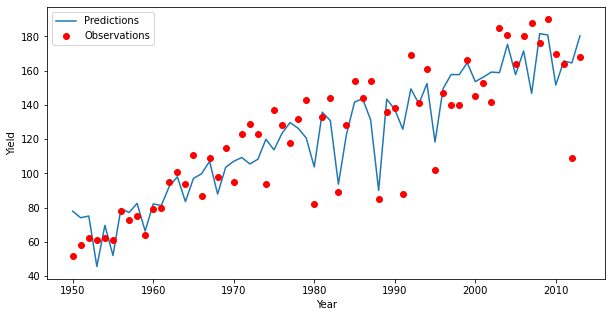

In [150]:
plot_linreg(17019) # Champaign county

In [88]:
results_reg[17019].coef_

array([ 1.79208186e+00,  4.01567624e-02,  8.39574778e-03, -5.88865522e-05,
       -9.89963096e-01, -1.26111761e+00, -4.59902318e-01])

In [89]:
(np.array(list(results_r2_5fcv.values())) > 0.).mean()

0.20595968448729185

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [113]:
%%time
# Random forest
results_regr = {}
results_regr_r2_5fcv = {}

for fips in df.index.unique():
    X = df.loc[fips][predictors].to_numpy()
    y = df.loc[fips]['yield'].to_numpy()
    
    if len(y) > 30:
#         regr = RandomForestRegressor(max_depth=2)
#         regr.fit(X, y)
#         results_regr.update({fips : reg})
        results_regr_r2_5fcv.update({fips : np.mean(cross_val_score(RandomForestRegressor(n_estimators=50, max_depth=2), X, y, cv=5, scoring='r2'))})

CPU times: user 8min 38s, sys: 6.34 s, total: 8min 44s
Wall time: 8min 46s


In [114]:
(np.array(list(results_regr_r2_5fcv.values())) > 0.).mean()

0.0043821209465381246

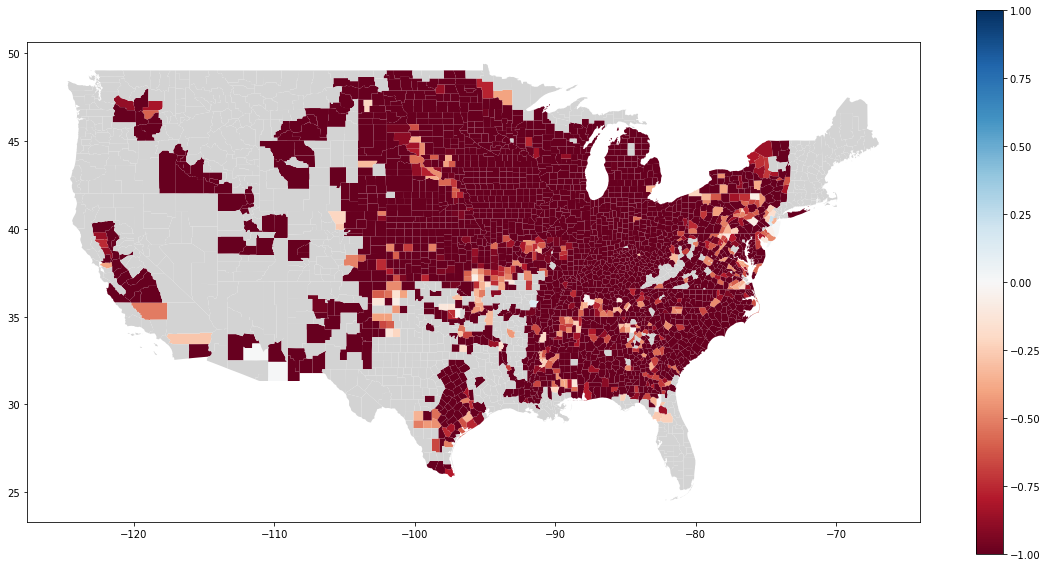

In [115]:
# Merge to plot
df_results = pd.DataFrame.from_dict(results_regr_r2_5fcv, orient='index', columns = ['R2']).reset_index()
df_results = pd.merge(geoData, df_results, right_on = 'index', left_on = 'id', how='outer')

# Plot R2
fig, ax = plt.subplots(figsize=(20,10))

df_results.plot(column = 'R2', ax=ax, legend=True, cmap = 'RdBu', missing_kwds={'color': 'lightgrey'}, vmin=-1., vmax=1.)

plt.show()